In [3]:
# 1. Import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score,
    roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [11]:
# 2. Load data
df = pd.read_csv(r"E:\Machine Learning\Assignment_Data.csv")

In [12]:
# 3: Data Exploration & Cleaning

# shape and head
print("Shape:", df.shape)
display(df.head())

# Check columns & datatypes
print("\nColumns and Types:")
print(df.dtypes)

# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic class balance for 'readmitted_30_days'
print("\nClass Balance:")
print(df['readmitted_30_days'].value_counts(normalize=True))

# statistics
display(df.describe(include='all'))

Shape: (200, 9)


,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...



Columns and Types:
patient_id                  int64
age                         int64
gender                     object
diagnosis_code             object
num_previous_admissions     int64
medication_type            object
length_of_stay              int64
readmitted_30_days          int64
discharge_note             object
dtype: object

Missing Values:
patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

Class Balance:
readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64


,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
count,200.000000,200.000000,200,200,200.000000,200,200.000000,200.00000,200
unique,NaN,NaN,2,4,NaN,3,NaN,NaN,10
top,NaN,NaN,Female,D001,NaN,Type B,NaN,NaN,Discharge after recovery from pneumonia. No co...
freq,NaN,NaN,107,56,NaN,69,NaN,NaN,25
mean,100.500000,53.720000,NaN,NaN,1.600000,NaN,7.865000,0.32500,NaN
std,57.879185,21.294574,NaN,NaN,1.310951,NaN,4.134276,0.46955,NaN
min,1.000000,20.000000,NaN,NaN,0.000000,NaN,1.000000,0.00000,NaN
25%,50.750000,34.000000,NaN,NaN,1.000000,NaN,4.000000,0.00000,NaN
50%,100.500000,54.000000,NaN,NaN,1.000000,NaN,8.000000,0.00000,NaN
75%,150.250000,73.000000,NaN,NaN,2.000000,NaN,11.000000,1.00000,NaN


In [15]:
# 4. Feature Engineering - Bin age into categories
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 100], labels=['Young', 'Middle-aged', 'Senior'])
print(df['age_group'].value_counts())

age_group
Senior         85
Young          65
Middle-aged    50
Name: count, dtype: int64


In [24]:
# 5. Encoding categorical variables (Label Encoding for XGBoost)
cat_cols = ['gender', 'diagnosis_code', 'medication_type', 'age_group']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
print(df['gender'].value_counts())
print(df['diagnosis_code'].value_counts())
print(df['medication_type'].value_counts())
print(df['age_group'].value_counts())

gender
0    107
1     93
Name: count, dtype: int64
diagnosis_code
0    56
1    54
3    53
2    37
Name: count, dtype: int64
medication_type
1    69
0    67
2    64
Name: count, dtype: int64
age_group
1    85
2    65
0    50
Name: count, dtype: int64


In [25]:
# 6. Dropping non-predictive columns
#The column discharge_note contains free-text (unstructured) data.
#The XGBoost model in model is only using structured features (numerical and categorical columns).
df_model = df.drop(columns=['patient_id', 'discharge_note'])

In [26]:
# 7. Define features and target
X = df_model.drop('readmitted_30_days', axis=1)
y = df_model['readmitted_30_days']

In [27]:
# 8. Train-test split (stratify ensures balanced split for classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
# 9.SMOTE oversampling 
# dataset has more of "not readmitted" (0) cases than "readmitted" (1) cases.
# Helps avoid a situation where the model achieves high accuracy by always predicting the majority class.
# A model trained on imbalanced data might just learn to predict the majority class and ignore the minority class.
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [31]:
# 10. Train XGBoost Classifier with tuned parameters
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=2 # because the classes are imbalanced
)
xgb_clf.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:29:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
# 11. Predictions
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:,1]

In [33]:
# 12. All Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.3f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR AUC (Average Precision): {average_precision_score(y_test, y_proba):.3f}")

Accuracy: 0.550
Precision: 0.381
Recall (Sensitivity): 0.615
F1-score: 0.471
Balanced Accuracy: 0.567
Matthews Correlation Coefficient: 0.126
Cohen's Kappa: 0.115
ROC AUC: 0.570
PR AUC (Average Precision): 0.436


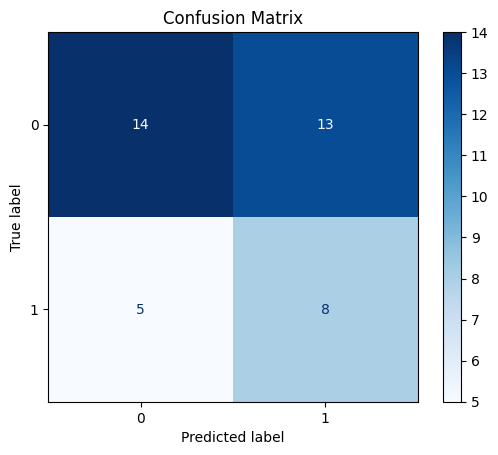

In [34]:
# 13. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


<Figure size 800x500 with 0 Axes>

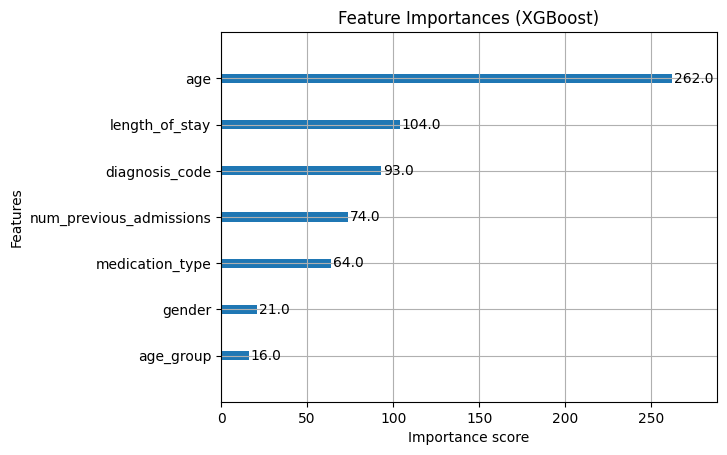

In [35]:
# 14. Feature Importance Plot
plt.figure(figsize=(8,5))
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.title("Feature Importances (XGBoost)")
plt.show()

In [36]:
# Run NER (Named Entity Recognition) on first Discharge Note
# Quick check to test if pipeline and model are working.
from transformers import pipeline

# Load pre-trained NER pipeline (general English NER)
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# Test on a single note (for speed)
sample_note = df['discharge_note'][0]
print("Sample note:", sample_note)
print("\nEntities found:")
print(ner_pipeline(sample_note))


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Sample note: Good recovery trajectory. Follow-up scan scheduled next month.

Entities found:
[]


In [43]:
# Apply NER to first 5 discharge notes for demo
for i, note in enumerate(df['discharge_note'][:5]):
    print(f"\n--- Discharge Note #{i+1} ---")
    print("Text:", note)
    entities = ner_pipeline(note)
    if entities:
        for ent in entities:
            print(f"Entity: {ent['word']}, Label: {ent['entity_group']}, Score: {ent['score']:.2f}")
    else:
        print("No known entity found.")



--- Discharge Note #1 ---
Text: Good recovery trajectory. Follow-up scan scheduled next month.
No known entity found.

--- Discharge Note #2 ---
Text: Stable post-surgery. Advised to avoid physical exertion.
No known entity found.

--- Discharge Note #3 ---
Text: Symptoms controlled. Monitoring for relapse advised.
No known entity found.

--- Discharge Note #4 ---
Text: Stable post-surgery. Advised to avoid physical exertion.
No known entity found.

--- Discharge Note #5 ---
Text: Stable post-surgery. Advised to avoid physical exertion.
No known entity found.


In [44]:
# Prompt-Based Approach With Flan-T5
# Prompt-based LLMs with a custom prompt.
from transformers import pipeline

# Use Flan-T5 for prompt-based extraction
t5 = pipeline("text2text-generation", model="google/flan-t5-base", max_length=128)

prompt = (
    "Extract key clinical entities from the following discharge note. "
    "Categorize each as diagnosis, treatment, symptom, medication, or follow-up action:\n"
    f"{sample_note}"
)
result = t5(prompt)[0]['generated_text']
print("Entities extracted:\n", result)


Device set to use cpu


Entities extracted:
 diagnosis, treatment, symptom, medication


In [38]:
# Using Flan-T5 and prompt engineering for Consistent LLM Output

sample_note = df['discharge_note'][0]

prompt = (
    "Extract all key clinical entities from the discharge note below. "
    "For each entity, specify the type in parentheses: diagnosis, treatment, symptom, medication, or follow-up action. "
    "Format: one entity per line, like this: <entity> (<type>)\n"
    f"Discharge note: {sample_note}"
)

# Generate result using Flan-T5
result = t5(prompt)[0]['generated_text']

print("Prompted Output:\n")
print(result)


Prompted Output:

entity> (type>) Discharge note: Good recovery trajectory. Follow-up scan scheduled next month.
